In [ ]:
# IMPROVEMENT: 
# CAN'T JUST VARY DIFF_MU, MUST VARY DIFF_SIGMA TOO FOR MEANINGFUL CHARTS

In [10]:
# DRO Synthetic Data

Definitions:
- target vol = ρ
- out-of-sample vol = σ_oos
- gap = σ_oos − ρ
- vol_breach  = max(0, σ_oos − ρ)
- EEP = mean(r_dro - r_mvo)  # expected excess performance.           
- EEV = mean(σ_oos - ρ)+     # expected excess volatility.           

Segments: 
- First segment: positive drift, lower vol:   
$
\mu_1 = +\tfrac{\Delta \mu}{2}, \quad \sigma_1 = \sigma - \tfrac{\Delta \sigma}{2}
$

- Second segment: negative drift, higher vol:   
$
\mu_2 = -\tfrac{\Delta \mu}{2}, \quad \sigma_2 = \sigma + \tfrac{\Delta \sigma}{2}
$

In [12]:
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy import stats
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/Users/chrismader/Python/DRO")
sys.path.insert(0, "/Users/chrismader/Python/SLDS")
from dro import *
from rSLDS import *

import warnings
warnings.filterwarnings("ignore")
np.seterr(all="ignore")


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [13]:
# ---------------------------------------------------------------
# Genereate Synthetic Data
# ---------------------------------------------------------------

def generate_synthetic_data(mu_diff, sigma, sigma_diff, Mk, Nk, jitter=0, dt=1/252, rng=None, display=False):

    if rng is None:
        rng = np.random.default_rng()

    mu1 = +mu_diff / 2
    mu2 = -mu_diff / 2
    sigma1 = sigma - sigma_diff / 2
    sigma2 = sigma + sigma_diff / 2

    # Generate jittered segment lengths around Nk
    low  = max(1, Nk - jitter)
    high = Nk + jitter + 1
    segment_lengths = rng.integers(low, high, size=Mk)
    total_steps = segment_lengths.sum()

    regimes = [i % 2 for i in range(Mk)]
    z_true = np.empty(total_steps, dtype=int)
    drift_series = np.empty(total_steps)
    diffusion_series = np.empty(total_steps)

    idx = 0
    for regime, L in zip(regimes, segment_lengths):
        z_true[idx:idx + L] = regime
        drift_series[idx:idx + L] = mu1 if regime == 0 else mu2
        diffusion_series[idx:idx + L] = sigma1 if regime == 0 else sigma2
        idx += L

    prices = np.empty(total_steps + 1)
    prices[0] = 1.0
    dW = rng.standard_normal(total_steps) * np.sqrt(dt)

    for t in range(total_steps):
        prices[t + 1] = prices[t] + drift_series[t] * prices[t] * dt + diffusion_series[t] * prices[t] * dW[t]

    log_returns = np.diff(np.log(prices))
    prices = prices[1:]  # align with log_returns
    prices = pd.Series(prices, name="price")
    
    if display:
        fig, axs = plt.subplots(3, 1, figsize=(8, 3), sharex=True)
        t = np.arange(len(prices))

        axs[0].plot(t, prices)
        axs[1].plot(t, log_returns)
        axs[2].plot(t, z_true)

        # Add vertical lines at regime boundaries
        switch_points = np.cumsum(segment_lengths)[:-1]
        for x in switch_points:
            axs[0].axvline(x=x, color='k')
            axs[1].axvline(x=x, color='k')

        axs[0].set_ylabel('Price')
        axs[1].set_ylabel('Log return')
        axs[1].set_xlabel('Time step')
        plt.tight_layout()
        plt.show()

    return {
        "prices": prices,
        "y": log_returns[:, None],
        "z_true": z_true,
        "segment_lengths": segment_lengths}


def _build_data_synth(trial_id, G, S):
    """
    Build an (n_days x n_assets) return matrix using the user's
    generate_synthetic_data(mu_diff, sigma, sigma_diff, Mk, Nk, ...).

    All assets share the SAME segmentation (taus) so we can form
    a single `taus_true` for Regime-DRO. Each asset draws its own
    mu_diff and sigma_diff from the specified ranges.
    """
    rng_base = np.random.default_rng(G["seed_base"] + trial_id)

    # ---- read spec ----
    n_assets = int(S["n_assets"])
    # we force common segmentation: total length = Mk * Nk
    Mk      = int(S.get("Mk", S.get("n_regimes", 6)))        # number of segments
    Nk      = int(S.get("Nk", S.get("n_days", 252) // Mk))   # steps per segment
    jitter  = int(S.get("jitter", 0))                        # keep 0 so boundaries match
    assert jitter == 0, "Set jitter=0 so all assets share the same segment lengths."
    n_days  = Mk * Nk

    mu_lo, mu_hi     = map(float, S["range_mu_diff"])
    sig_lo, sig_hi   = map(float, S["range_sigma_diff"])
    sigma_base       = float(S.get("sigma_base", 0.20))
    dt               = 1.0 / 252.0                           # keep annualization consistent

    # Pre-draw per-asset parameters ONCE and reuse for train/test
    mu_diff_vec   = rng_base.uniform(mu_lo,  mu_hi,  size=n_assets)
    sig_diff_vec  = rng_base.uniform(sig_lo, sig_hi, size=n_assets)

    # ---- TRAIN series (log-returns) ----
    log_train_cols = []
    taus = None
    for j in range(n_assets):
        g = generate_synthetic_data(
            mu_diff=float(mu_diff_vec[j]),
            sigma=sigma_base,
            sigma_diff=float(sig_diff_vec[j]),
            Mk=Mk, Nk=Nk, jitter=jitter, dt=dt,
            rng=np.random.default_rng(G["seed_base"] + 10_000*trial_id + j),
            display=False
        )
        if taus is None:
            # shared boundaries
            seg_lengths = g["segment_lengths"]
            assert len(seg_lengths) == Mk
            taus = [0] + np.cumsum(seg_lengths).tolist()
            assert taus[-1] == n_days
        log_train_cols.append(g["y"].ravel())

    log_train = np.column_stack(log_train_cols)                 # (n_days, n_assets)
    train     = np.expm1(log_train)                             # arithmetic returns

    # ---- TEST series (log-returns) ----
    log_test_cols = []
    for j in range(n_assets):
        g = generate_synthetic_data(
            mu_diff=float(mu_diff_vec[j]),
            sigma=sigma_base,
            sigma_diff=float(sig_diff_vec[j]),
            Mk=Mk, Nk=Nk, jitter=jitter, dt=dt,
            rng=np.random.default_rng(G["seed_base"] + 20_000*trial_id + j),
            display=False
        )
        log_test_cols.append(g["y"].ravel())

    log_test = np.column_stack(log_test_cols)
    test     = np.expm1(log_test)

    # ---- full-sample estimates for optimizer (annualized, from log-returns) ----
    mu_daily  = log_train.mean(axis=0)
    Sigma_d   = np.cov(log_train.T, ddof=1)
    Sigma_ann = Sigma_d * 252.0                                 # annualize by 252
    mu_ann    = np.expm1(mu_daily * 252.0)

    return {
        "train": train,
        "test":  test,
        "taus_true": taus,                 # [0, τ1, …, n_days] shared across assets
        "mu_ann_full": mu_ann,
        "Sigma_ann_full": Sigma_ann,
        "n_days": n_days, 
        "ann_factor": 252,
    }


def build_data(trial_id: int, global_cfg: dict, data_cfg: dict):
    """Dispatch to synthetic (your new generator) or actual loader."""
    if data_cfg["type"] == "synthetic":
        return _build_data_synth(trial_id, global_cfg, data_cfg["gbm"])
    elif data_cfg["type"] == "actual":
        return _build_data_actual(trial_id, global_cfg, data_cfg)
    else:
        raise ValueError("unknown data_cfg['type']")


# ---------------------------------------------------------------
# rSLDS pipelines
# ---------------------------------------------------------------

_RSLDS_CACHE = {}

def _rslds_fingerprint(y_tr: np.ndarray, cfg: dict, h_z: int, seed):
    # stable key for a given dataset + rSLDS hyperparams
    s1 = float(np.sum(y_tr))
    s2 = float(np.sum(y_tr**2))
    return ("rSLDS",
            len(y_tr), round(s1, 12), round(s2, 12),
            int(cfg["n_regimes"]), int(cfg["dim_latent"]),
            bool(cfg["single_subspace"]), int(cfg["n_iter_em"]),
            float(cfg["dt"]), int(h_z), seed)

def returns_to_prices(R, S0=100.0):
    P = np.empty((R.shape[0]+1, R.shape[1])); P[0]=S0; P[1:] = S0*np.cumprod(1+R, axis=0); return P

def rslds_pipeline(data, params, G):
    R_tr, R_te = data["train"], data["test"]; n_days = data["n_days"]
    K    = int(params.get("n_regimes", 3))
    rpar = dict(params.get("rslds", {}))
    cfg  = {"n_regimes": K,
            "dim_latent": int(rpar.get("dim_latent",1)),
            "single_subspace": bool(rpar.get("single_subspace",True)),
            "n_iter_em": int(rpar.get("n_iter_em",50)),
            "dt": float(rpar.get("dt", 1.0/n_days))}
    h_z  = int(rpar.get("h_z",10))
    seed = rpar.get("seed", None)

    # price Series and observations
    P_tr = returns_to_prices(R_tr, 100.0); P_te = returns_to_prices(R_te, 100.0)
    px_tr = pd.Series(P_tr.mean(axis=1), name="price")
    px_te = pd.Series(P_te.mean(axis=1), name="price")
    y_tr  = np.log(px_tr.values[1:]).reshape(-1,1)
    y_te  = np.log(px_te.values[1:]).reshape(-1,1)

    # cache lookup
    key = _rslds_fingerprint(y_tr, cfg, h_z, seed)
    if key in _RSLDS_CACHE:
        diag = _RSLDS_CACHE[key]
        data["rslds_diag"] = diag
        return diag["segs"]

    # fit (TRAIN)
    x_tr, z_tr, elbo, q, mdl = fit_rSLDS(y=y_tr, params=cfg, n_iter_em=cfg["n_iter_em"], seed=seed)
    z_tr = np.asarray(z_tr, int).ravel()

    # inference and CUSUM (TEST)
    inf  = inference_rSLDS(px=px_te, mdl=mdl, y_test=y_te, y_train=y_tr, dt=cfg["dt"], display=False)
    z_te = np.asarray(inf["zhat"], int).ravel()
    z_cu = cusum_overlay(px_te, y_te, inf["xhat"], mdl, h_z=h_z)
    z_te_final = np.asarray(z_cu, int).ravel() if z_cu is not None else z_te

    # evaluate (TEST)
    _ = evaluate_rSLDS_synthetic(px_te, y_te, inf["xhat"], z_te_final,
                                 np.zeros(n_days, int), elbo, mdl, inf["cpll"], inf["max_cpll"],
                                 display=False)

    # segments from TRAIN labels (no shift)
    cps  = np.where(z_tr[1:] != z_tr[:-1])[0] + 1
    segs = [0] + cps.tolist() + [n_days]
    segs = [segs[0]] + [b for a,b in zip(segs[:-1], segs[1:]) if b > a]
    if segs[-1] != n_days: segs[-1] = n_days

    # stash & cache
    diag = {"key": key, "z_tr": z_tr.tolist(), "z_te": z_te.tolist(),
            "z_te_final": z_te_final.tolist(), "segs": segs}
    _RSLDS_CACHE[key] = diag
    data["rslds_diag"] = diag
    return segs

# ---------------------------------------------------------------
# DRO pipelines
# ---------------------------------------------------------------

def build_data_cache(GLOBAL, DATA_SPEC):
    """Pre-generate the list of per-trial data dicts to reuse across models/κ."""
    return [build_data(trial_id=i, global_cfg=GLOBAL, data_cfg=DATA_SPEC)
            for i in range(GLOBAL["n_trials"])]

def run_trials_from_cache(GLOBAL, PORTFOLIOS, DATA_CACHE):
    """Same as run_trials, but consumes a prebuilt DATA_CACHE (no regeneration)."""
    accum = {spec["name"]: [] for spec in PORTFOLIOS}
    for data in DATA_CACHE:
        summaries = {}
        for spec in PORTFOLIOS:
            fit = spec["fit_fn"](data, spec.get("params", {}), GLOBAL)
            summaries[spec["name"]] = evaluate_portfolio(fit, data, GLOBAL)
        for name, row in summaries.items():
            accum[name].append(row)
    return {k: pd.DataFrame(v) for k, v in accum.items()}

def sweep_kappa_from_cache(GLOBAL, DATA_CACHE, PORTFOLIOS, model_name, grid, set_param):
    """
    Run a κ-sweep for a single model using the same DATA_CACHE for all κ.
    Returns: {kappa_value: results_dict_from_run_trials}
    """
    base = next(s for s in PORTFOLIOS if s["name"] == model_name)
    runs = {}
    for k in map(float, grid):
        spec_k = dict(base, params=dict(base.get("params", {})))
        set_param(spec_k["params"], k)
        runs[k] = run_trials_from_cache(GLOBAL, [spec_k], DATA_CACHE)
    return runs

def run_single_trial(trial_id, GLOBAL, DATA_SPEC, PORTFOLIOS):
    data = build_data(trial_id, GLOBAL, DATA_SPEC)
    summaries = {}
    arts = {"data": data}
    for spec in PORTFOLIOS:
        fit = spec["fit_fn"](data, spec.get("params", {}), GLOBAL)
        summaries[spec["name"]] = evaluate_portfolio(fit, data, GLOBAL)
        # optional artifacts
        if fit["type"] == "static":
            arts[spec["name"]] = {"w": fit["w"]}
        else:
            arts[spec["name"]] = {
                "w_list": fit["w_list"],
                "segs": fit["segs"],
                "delta_list": fit.get("delta_list", [])}
    return {"summary": summaries, "artifacts": arts}

def run_trials(GLOBAL, DATA_SPEC, PORTFOLIOS):
    accum = {spec["name"]: [] for spec in PORTFOLIOS}
    for i in range(GLOBAL["n_trials"]):
        out = run_single_trial(i, GLOBAL, DATA_SPEC, PORTFOLIOS)
        for name, row in out["summary"].items(): accum[name].append(row)
    return {k: pd.DataFrame(v) for k, v in accum.items()}

def run_one_trial(GLOBAL, DATA_SPEC, PORTFOLIOS):
    out = run_single_trial(0, GLOBAL, DATA_SPEC, PORTFOLIOS)
    data = out["artifacts"]["data"]; rho = GLOBAL["risk_budget"]
    for spec in PORTFOLIOS:
        name = spec["name"]; art = out["artifacts"].get(name, {})
        if "w" in art:
            print_single_portfolio_block(
                name, art["w"], data["train"], data["test"], rho, data["Sigma_ann_full"], 
                {"epsilon_sigma": GLOBAL["epsilon_sigma"], "n_days": data["n_days"], "risk_free_rate": GLOBAL["risk_free_rate"]})
        elif "w_list" in art:
            print_regime_block(
                name, data["train"], data["test"],
                art["w_list"], art["segs"], rho,
                taus_display=data.get("taus_true", [0, data["n_days"]]),
                seg_deltas=art.get("delta_list", []))

def run_all_trials(GLOBAL, DATA_SPEC, PORTFOLIOS, tests, sweeps=None, show_summary=True):
    DATA_CACHE = build_data_cache(GLOBAL, DATA_SPEC)
    results = run_trials_from_cache(GLOBAL, PORTFOLIOS, DATA_CACHE)
    order = [s["name"] for s in PORTFOLIOS]
    if show_summary:
        print_oos_table(results, model_order=order)
    hypothesis_tests(results, tests=tests, alpha=0.05)
    if sweeps:
        for sw in sweeps:
            runs  = sweep_kappa_from_cache(GLOBAL, DATA_CACHE, PORTFOLIOS, sw["model"], sw["grid"], sw["set_param"])
            curve = collect_kappa_curve(runs, sw["model"])
            plot_kappa_panels(curve, sw["model"])
    return results, DATA_CACHE

def sweep_kappa(GLOBAL, DATA_SPEC, PORTFOLIOS, model_name: str, grid, set_param):
    """
    set_param: function(params_dict, kappa) -> None
    Returns: {kappa_value: results_dict_from_run_trials}
    """
    runs = {}
    for k in map(float, grid):
        specs = [dict(s, params=dict(s.get("params", {}))) for s in PORTFOLIOS]  # deep-ish copy
        for s in specs:
            if s["name"] == model_name:
                set_param(s["params"], k)
        runs[k] = run_trials(GLOBAL, DATA_SPEC, specs)
    return runs


# ---------------------------------------------------------------
# Portfolio & sweep factories (declarative config, no duplication)
# ---------------------------------------------------------------

def build_portfolios(select, data_spec):
    """
    select = {
        "optimizers": ["MVO","DRO","Regime-DRO","rSLDS-DRO"],
        "deltas":     [... keys of DELTA_DEFAULTS ...]}
    """
    specs = []

    if "MVO" in select["optimizers"]:
        specs.append({"name": "MVO", "fit_fn": fit_mvo, "params": {"kappa": 0.0}})

    for dname in select["deltas"]:
        base = dict(DELTA_DEFAULTS[dname])

        if "DRO" in select["optimizers"]:
            specs.append({"name": f"DRO[{dname}]", "fit_fn": fit_dro, "params": dict(base)})

        if "Regime-DRO" in select["optimizers"]:
            p = dict(base); p.update({"delay": 0})
            specs.append({"name": f"Regime-DRO[{dname}]",
                          "fit_fn": fit_regime_dro, "params": p})

        if "rSLDS-DRO" in select["optimizers"]:
            p = dict(base); p.update({
                "n_regimes": data_spec["gbm"]["n_regimes"],
                "segs_fn": rslds_pipeline,
                "rslds": dict(RSLDS_DEFAULTS),})
            specs.append({"name": f"rSLDS-DRO[{dname}]",
                          "fit_fn": fit_regime_dro, "params": p})
    return specs

def build_sweeps(portfolios, grid):
    sweeps = []
    for spec in portfolios:
        if str(spec["params"].get("delta_method", "")).startswith("kappa_"):
            sweeps.append({
                "model": spec["name"],
                "grid": list(map(float, grid)),
                "set_param": (lambda params, k: params.update({"kappa": float(k)}))})
    return sweeps

def make_tests(baseline_delta="kappa_l2"):
    def nm(tag):  # model name helper
        return "MVO" if tag == "MVO" else f"{tag}[{baseline_delta}]"
    return [
        {"kind": "breach_less",         "A": nm("DRO"),         "B": "MVO"},
        {"kind": "equality_sharpe",     "A": nm("DRO"),         "B": "MVO"},
        {"kind": "superiority_sharpe",  "A": nm("Regime-DRO"),  "B": nm("DRO")},
        {"kind": "breach_less",         "A": nm("rSLDS-DRO"),   "B": nm("Regime-DRO")},
        {"kind": "superiority_sharpe",  "A": nm("rSLDS-DRO"),   "B": nm("DRO")},]

def filter_tests(tests, portfolios):
    names = {p["name"] for p in portfolios}
    return [t for t in tests if t["A"] in names and t["B"] in names]


# ---------------------------------------------------------------
# Execute
# ---------------------------------------------------------------

if __name__ == "__main__":

    DATA_SYNTH = {"type": "synthetic", "gbm": {
        "n_assets": 30,
        # segmentation: choose Mk that divides 252 (e.g., 6 → Nk=42)
        "Mk": 2,            # number of segments per series
        "Nk": 126,          # steps per segment; Mk*Nk must equal your horizon
        "jitter": 0,        # keep 0 so taus match across assets
    
        # your ranges for per-asset parameter draws
        "range_mu_diff":    [0.0, 0.6],   # Δμ (annual units)
        "range_sigma_diff": [0.1, 0.3],   # Δσ (annual units)    ###
        "sigma_base": 0.20,               # base σ around which Δσ is applied
    
        # the following two are *not* used by this generator but may exist elsewhere
        "n_days": 252,      # implied by Mk*Nk; kept for clarity
        "S0": 100}}

    DATA_SPEC = DATA_SYNTH

    # Select here which optimizers to run
    SELECT = {
        "optimizers": ["MVO", "DRO", "Regime-DRO"],
        # "optimizers": ["MVO", "DRO", "Regime-DRO", "rSLDS-DRO"],
        "deltas": ["kappa_l2", "kappa_rate", "bound_ek", "bootstrap_np", "bootstrap_gaussian"]
    }

    DELTA_DEFAULTS = {
    "kappa_l2":           {"delta_method": "kappa_l2",           "kappa": 1.0},
    "kappa_rate":         {"delta_method": "kappa_rate",         "kappa": 1.0},
    "bound_ek":           {"delta_method": "bound_ek",           "alpha": 0.05, "c1": 3.0, "c2": 1.0, "a": 2.0},
    "bootstrap_np":       {"delta_method": "bootstrap_np",       "alpha": 0.05, "B": 100, "seed": 0, },
    "bootstrap_gaussian": {"delta_method": "bootstrap_gaussian", "alpha": 0.05, "B": 100, "seed": 0, }, }

    RSLDS_DEFAULTS = {"dim_latent": 1, "single_subspace": True, "n_iter_em": 50, "h_z": 3.0}   # set

    PORTFOLIOS = build_portfolios(SELECT, DATA_SPEC)

    # κ-sweeps only for kappa_* deltas
    GRID_KAPPA = [0.0, 0.25, 0.5, 1.0, 2.0, 4.0]
    SWEEPS = build_sweeps(PORTFOLIOS, GRID_KAPPA)

    # pick a baseline delta for hypothesis tests (must be in SELECT["deltas"])
    TESTS = filter_tests(make_tests(baseline_delta="kappa_l2"), PORTFOLIOS)

    GLOBAL = {"risk_budget": 0.30, "epsilon_sigma": 1e-6,
              "risk_free_rate": 0.0, "seed_base": 0, "n_trials": 10}   # set 100

    run_one_trial(GLOBAL, DATA_SPEC, PORTFOLIOS)
    
    base_results, DATA_CACHE = run_all_trials(
        GLOBAL, DATA_SPEC, PORTFOLIOS, tests=TESTS, sweeps=None, show_summary=True)




MVO

TRAIN SAMPLE STATISTICS:
n_assets: 30
n_days:   252
Max mean return (annualized): 0.2818
Min mean return (annualized): -0.7630
Max volatility (annualized) : 0.2652
Min volatility (annualized) : 0.1923

TRAIN PORTFOLIO (on Σ_train, μ_train):
Annualized expected return:   1.8992
Annualized risk (vol)     :   0.3000
Risk bound ρ              :   0.3000
Train constraint satisfied:   True
Gross exposure (‖w‖₁)     :   6.8171

Top 3 assets with largest weights:
Asset  4: weight = +0.5064, μ = +0.2744, σ = 0.2211
Asset  6: weight = +0.3831, μ = +0.2818, σ = 0.2286
Asset 29: weight = +0.3313, μ = +0.1421, σ = 0.2122

Top 3 assets with smallest nonzero weights:
Asset 10: weight = -0.5241, μ = -0.7630, σ = 0.2338
Asset 24: weight = -0.4510, μ = -0.5877, σ = 0.2190
Asset 20: weight = -0.4406, μ = -0.4651, σ = 0.2197

EVAL / OOS PORTFOLIO (on Σ_eval, μ_eval):
OOS annualized return     : 1.8992
OOS annualized risk (vol) : 0.2985
Risk bound ρ              : 0.3000

DRO[kappa_l2]

TRAIN SAMPLE 

#### Discussion

Why does rSLSD-DRO show a significantly lower Sharpe ratio (~0.75) at κ = 0,  
while MVO and DRO (with κ = 0) both show Sharpe ≈ 0.96?

If $\kappa = 0$ disables the robustness penalty, all methods should reduce to MVO.  
But the Sharpe for rSLSD-DRO does not match — why?

We are not seeing equality at $\kappa = 0$ because the rSLSD path re-estimates $(\mu, \Sigma)$ per piece and re-optimizes per piece.

Setting $\kappa = 0$ only removes the DRO penalty; it does not make rSLSD use the full-sample $(\mu, \Sigma)$, nor a single static weight vector.

So at $\kappa = 0$ we are running segment-wise MVO with segment-wise $\Sigma$ and a piecewise trading policy, which will generally have a different OOS Sharpe than full-sample MVO/DRO.

---

Gelbrich formula. When the sample size is large enough, the parameters of the second model will be almost identical to the first. We essentially measure the distance between a distribution and a near-perfect copy of itself, which is why the delta was always near zero.



Tuned a single δ per model to hit GLOBAL EEV ≤ 0.01
        model  delta_star  eev_achieved  delta_tw  delta_k1  delta_k2  eev_achieved_k1  eev_achieved_k2
0         MVO    0.000000      0.049087       NaN       NaN       NaN              NaN              NaN
1         DRO    0.886475      0.010000       NaN       NaN       NaN              NaN              NaN
2  Regime-DRO    1.170074           NaN  1.170074       0.0  2.340149              0.0         0.009991

OOS Portfolio Performance Summary (mean ± std bounds)
                                 MVO                        DRO                 Regime-DRO
mu_ann      0.6078 (-1.0942, 2.3098)   0.5527 (-0.9941, 2.0994)    0.3742 (0.0101, 0.7384)
sigma_ann    0.3469 (0.3052, 0.3886)    0.2799 (0.2082, 0.3515)    0.1773 (0.1237, 0.2308)
sharpe_ann  0.8738 (-1.3325, 3.0801)   0.7921 (-1.3747, 2.9588)    1.7957 (0.2280, 3.3634)
vol_breach   0.0491 (0.0109, 0.0873)   0.0100 (-0.0067, 0.0267)    0.0000 (0.0000, 0.0000)
p_viol       0.8000 (

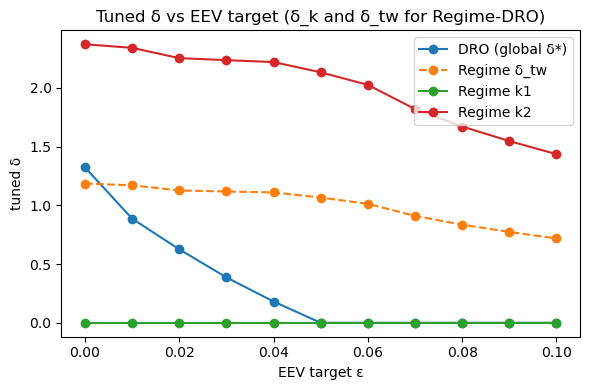

In [15]:

# ---------------------------------------------------------------
# κ-sweep curve helpers
# ---------------------------------------------------------------

def collect_kappa_curve(results_by_kappa: dict, model: str) -> pd.DataFrame:
    """
    results_by_kappa: {kappa_value: results_dict_from_run_trials}
    model: portfolio name to pull from results (e.g., "DRO", "Regime-DRO").
    """
    rows = []
    for kappa, res in sorted(results_by_kappa.items(), key=lambda kv: kv[0]):
        df = res[model]
        need = {"vol_breach", "sharpe_ann", "gross_exp"}
        missing = need - set(df.columns)
        if missing:
            raise KeyError(f"{model}: missing {missing} in results; ensure gross_exp is recorded.")
        row = {
            "kappa": float(kappa),
            "vol_breach": df["vol_breach"].mean(),
            "p_viol": (df["vol_breach"] > 0).mean(),
            "Sharpe_mean": df["sharpe_ann"].mean(),
            "Sharpe_std": df["sharpe_ann"].std(ddof=1),
            "GrossExp_mean": df["gross_exp"].mean(),
            "GrossExp_std": df["gross_exp"].std(ddof=1),
        }
        if "gap" in df.columns:
            row["Gap_mean"] = df["gap"].mean()
            row["Gap_std"]  = df["gap"].std(ddof=1)
        if "delta" in df.columns:
            row["delta_mean"] = df["delta"].mean()
        rows.append(row)
    return pd.DataFrame(rows)

def plot_kappa_panels(curve_df: pd.DataFrame, title_prefix: str):

    print("\n" + "=" * 72)
    print("κ-SWEEP PLOTS")
    print("=" * 72)

    x = curve_df["kappa"].to_numpy()

    plt.figure(figsize=(5, 4))
    plt.plot(x, curve_df["vol_breach"], marker="o")
    plt.xlabel("kappa")
    plt.ylabel("vol_breach")
    plt.title(f"{title_prefix}: vol_breach vs δ-scale")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(x, curve_df["p_viol"], marker="o")
    plt.xlabel("kappa")
    plt.ylabel("p_viol")
    plt.title(f"{title_prefix}: Probability of violation vs δ-scale")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5, 4))
    plt.errorbar(x, curve_df["Sharpe_mean"], yerr=0.5 * curve_df["Sharpe_std"], fmt="o-", capsize=4)
    plt.xlabel("kappa")
    plt.ylabel("OOS Sharpe")
    plt.title(f"{title_prefix}: OOS Sharpe vs δ-scale (mean ± 0.5 sd)")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5, 4))
    plt.errorbar(x, curve_df["GrossExp_mean"], yerr=curve_df["GrossExp_std"], fmt="o-", capsize=4)
    plt.xlabel("kappa")
    plt.ylabel("‖w‖₁ (gross exposure)")
    plt.title(f"{title_prefix}: Gross Exposure vs δ-scale (mean ± sd)")
    plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# δ-as-hyperparam tuner targeting EEV (smallest δ with EEV ≤ ε)
# ---------------------------------------------------------------

def _eev(df):
    """Global EEV = E[(sigma_oos - rho)_+] = mean(vol_breach)"""
    return float(df["vol_breach"].mean())

def _eev_k(df, k):
    """Per-segment EEV_k = mean(vol_breach_k)"""
    col_name = f"vol_breach_k{k+1}"
    if col_name not in df.columns:
        return float("inf")
    return float(df[col_name].mean())

def run_trials_for_tuner(GLOBAL, PORTFOLIOS, DATA_CACHE):
    """Run using independent evaluator for piecewise models."""
    accum = {spec["name"]: [] for spec in PORTFOLIOS}
    for data in DATA_CACHE:
        summaries = {}
        for spec in PORTFOLIOS:
            fit = spec["fit_fn"](data, spec.get("params", {}), GLOBAL)
            if fit["type"] == "piecewise":
                summaries[spec["name"]] = evaluate_regime_independently(fit, data, GLOBAL)
            else:
                summaries[spec["name"]] = evaluate_portfolio(fit, data, GLOBAL)
        for name, row in summaries.items():
            accum[name].append(row)
    return {k: pd.DataFrame(v) for k, v in accum.items()}

def _run_one_model_for_tuner(GLOBAL, DATA_CACHE, spec):
    out = run_trials_for_tuner(GLOBAL, [spec], DATA_CACHE)
    return out[spec["name"]]

def _base_name(model_name: str):
    return model_name.split("[", 1)[0]

def _unique_base_specs(PORTFOLIOS):
    uniq = {}
    for s in PORTFOLIOS:
        b = _base_name(s["name"])
        if b not in uniq: uniq[b] = s
    order = ["MVO", "DRO", "Regime-DRO", "rSLDS-DRO"]
    return [uniq[k] for k in order if k in uniq] + [s for b,s in uniq.items() if b not in order]

def _spec_with_fixed_delta(spec, delta, new_name=None):
    """Return a spec that uses a fixed scalar δ via fit_dro_reverse (STATIC model)."""
    tuned = dict(spec, params=dict(spec.get("params", {})))
    tuned["name"] = new_name or spec["name"]
    tuned["fit_fn"] = fit_dro_reverse    
    tuned["params"].update({"delta": float(delta)})
    return tuned


# ---------- Global (single-δ) tuner ----------
def tune_delta_eev_for_spec(GLOBAL, DATA_CACHE, spec,
                            eev_target=0.0, d_hi=1.0, tol=1e-4,
                            max_expand=12, max_iter=32):
    """Smallest δ with E[(σ_oos-ρ)_+] ≤ ε for a single (global) model."""
    def eval_p(delta):
        tuned = _spec_with_fixed_delta(spec, float(delta), new_name=_base_name(spec["name"]))
        df = _run_one_model_for_tuner(GLOBAL, DATA_CACHE, tuned)
        return _eev(df)

    p0 = eval_p(0.0)
    if p0 <= eev_target:
        return 0.0, p0

    dH = float(d_hi); pH = eval_p(dH); m = 0
    while pH > eev_target and m < max_expand:
        dH *= 2.0
        pH = eval_p(dH)
        m += 1
    if pH > eev_target:      # couldn't hit target
        return dH, pH

    dL = 0.0
    for _ in range(max_iter):
        dm = 0.5*(dL + dH)
        pm = eval_p(dm)
        if pm <= eev_target: dH = dm
        else:                dL = dm
        if (dH - dL) <= tol: break
    return dH, eval_p(dH)

# ---------- Per-segment tuner for Regime-DRO ----------
def tune_delta_eev_per_segment(GLOBAL, DATA_CACHE, spec, segs,
                               eev_target=0.0, d_hi=1.0, tol=1e-4,
                               max_expand=12, max_iter=32):
    """
    Return [δ_k] with smallest δ_k s.t. E[(σ_oos,k - ρ)_+] ≤ ε for each segment k,
    evaluating with fit_regime_dro_rev.
    """
    K = len(segs) - 1
    delta_list = [0.0] * K

    def _eval_pk(k, dk, current_list):
        tuned = dict(spec, params=dict(spec.get("params", {})))
        tuned["name"] = _base_name(spec["name"])
        tuned["fit_fn"] = fit_regime_dro_rev_constSigma
        dl = list(current_list); dl[k] = float(dk)
        tuned["params"].update({"segs": segs, "delta_list": dl})
        df = _run_one_model_for_tuner(GLOBAL, DATA_CACHE, tuned)
        v = _eev_k(df, k)  # mean(vol_breach_k{k+1})
        return 0.0 if np.isnan(v) else float(v)

    for k in range(K):
        p0 = _eval_pk(k, 0.0, delta_list)
        if p0 <= eev_target:
            delta_list[k] = 0.0
            continue

        dH = float(d_hi); pH = _eval_pk(k, dH, delta_list); m = 0
        while pH > eev_target and m < max_expand:
            dH *= 2.0
            pH = _eval_pk(k, dH, delta_list)
            m += 1
        if pH > eev_target:
            delta_list[k] = dH
            continue

        dL = 0.0
        for _ in range(max_iter):
            dm = 0.5 * (dL + dH)
            pm = _eval_pk(k, dm, delta_list)
            if pm <= eev_target:
                dH = dm
            else:
                dL = dm
            if (dH - dL) <= tol:
                break
        delta_list[k] = float(dH)

    return delta_list

def tune_all_eev(GLOBAL, DATA_CACHE, PORTFOLIOS, eev_target=0.0, d_hi=1.0, tol=1e-4):
    """
    Main orchestrator for EEV tuning.
      - MVO: report baseline EEV.
      - DRO: tune one scalar δ to hit global EEV target.
      - Regime-DRO / rSLDS-DRO: tune one δ per segment to hit per-segment EEV target.
    """
    specs_base = _unique_base_specs(PORTFOLIOS)
    tuned_specs, rows = [], []
    
    for spec in specs_base:
        base_name = _base_name(spec["name"])

        if base_name == "MVO":
            df_mvo = _run_one_model_for_tuner(GLOBAL, DATA_CACHE, spec)
            rows.append({"model": base_name, "delta_star": 0.0, "eev_achieved": _eev(df_mvo)})
            tuned_specs.append(spec)

        elif base_name in ("Regime-DRO", "rSLDS-DRO"):
            # Resolve segments: explicit segs -> segs_fn(data0) -> taus_true
            segs = spec["params"].get("segs")
            if segs is None:
                segs_fn = spec["params"].get("segs_fn")
                if segs_fn is not None:
                    segs = segs_fn(DATA_CACHE[0], spec["params"], GLOBAL)
                else:
                    segs = DATA_CACHE[0].get("taus_true")
            assert segs is not None, "No segments found for Regime-DRO tuning."

            delta_list = tune_delta_eev_per_segment(GLOBAL, DATA_CACHE, spec, segs,
                                                    eev_target=eev_target, d_hi=d_hi, tol=tol)

            tuned = dict(spec, params=dict(spec["params"]))
            tuned["name"] = base_name
            tuned["fit_fn"] = fit_regime_dro_rev_constSigma
            tuned["params"].update({"segs": segs, "delta_list": delta_list})
            tuned_specs.append(tuned)

            weights = np.diff(np.array(segs))
            d_mean = float(np.dot(weights, np.array(delta_list)) / weights.sum()) if weights.sum() > 0 else 0.0

            final_results_df = _run_one_model_for_tuner(GLOBAL, DATA_CACHE, tuned)
            per_segment_breaches = [_eev_k(final_results_df, k) for k in range(len(delta_list))]
            global_eev_achieved = np.average(per_segment_breaches, weights=weights)

            row = {"model": base_name, "delta_star": d_mean, "delta_tw": d_mean}
            for k, dk in enumerate(delta_list, start=1):
                row[f"delta_k{k}"] = float(dk)                     # keep per-segment deltas
            for k in range(len(delta_list)):
                row[f"eev_achieved_k{k+1}"] = _eev_k(final_results_df, k)
            rows.append(row)

        else:
            d_star, p_star = tune_delta_eev_for_spec(GLOBAL, DATA_CACHE, spec,
                                                     eev_target=eev_target, d_hi=d_hi, tol=tol)
            tuned = _spec_with_fixed_delta(spec, d_star, new_name=base_name)
            tuned_specs.append(tuned)
            rows.append({"model": base_name, "delta_star": d_star, "eev_achieved": p_star})

    tune_report = pd.DataFrame(rows)
    final_results = run_trials_from_cache(GLOBAL, tuned_specs, DATA_CACHE)
    return tuned_specs, tune_report, final_results

# ---------------------------------------------------------------
# Checks
# ---------------------------------------------------------------

# Ensure DATA_CACHE exists for the checks
if "DATA_CACHE" not in globals():
    DATA_CACHE = build_data_cache(GLOBAL, DATA_SPEC)

# Pick base specs
spec_dro     = next(p for p in PORTFOLIOS if _base_name(p["name"]) == "DRO")
spec_regime  = next(p for p in PORTFOLIOS if _base_name(p["name"]) == "Regime-DRO")

# 1) DRO at δ=0 must be STATIC and include 'vol_breach'
df0 = _run_one_model_for_tuner(GLOBAL, DATA_CACHE,
                               _spec_with_fixed_delta(spec_dro, 0.0, new_name="DRO"))
assert "vol_breach" in df0.columns, "DRO sanity check failed: 'vol_breach' missing"

# 2) Regime-DRO with constant Σ: per-segment breaches must exist
segs = DATA_CACHE[0]["taus_true"]
dl   = [0.5] * (len(segs) - 1)

spec_reg_tuned = dict(spec_regime, params=dict(spec_regime["params"]))
spec_reg_tuned["fit_fn"] = fit_regime_dro_rev_constSigma
spec_reg_tuned["params"].update({"segs": segs, "delta_list": dl})

dfR = _run_one_model_for_tuner(GLOBAL, DATA_CACHE, spec_reg_tuned)
assert any(c.startswith("vol_breach_k") for c in dfR.columns), "Regime-DRO sanity check failed"

# ---------------------------------------------------------------
# Execute EEV tuning and curves
# ---------------------------------------------------------------

EEV_TARGET = 0.01

PORT_TUNED, tune_report, results = tune_all_eev(
    GLOBAL, DATA_CACHE, PORTFOLIOS, eev_target=EEV_TARGET, d_hi=2.0, tol=1e-4
)

print()
print("="*72)
print(f"Tuned a single δ per model to hit GLOBAL EEV ≤ {EEV_TARGET}")
print("="*72)
with pd.option_context("display.width", 160):
    print(tune_report)
print_oos_table(results, model_order=[s["name"] for s in PORT_TUNED])

# Sweep EEV targets and plot global δ* and per-segment δ_k* (with time-weighted δ_tw)
pgrid = np.array([0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10])

rows_dro, rows_reg = [], []
for eps in pgrid:
    tuned_specs, rep, _ = tune_all_eev(
        GLOBAL, DATA_CACHE, PORTFOLIOS, eev_target=float(eps), d_hi=1.0, tol=1e-4
    )
    rep = rep.copy(); rep["eev_target"] = float(eps)

    # Global DRO scalar δ*
    r_dro = rep.loc[rep["model"] == "DRO"]
    if not r_dro.empty:
        rows_dro.append({
            "eev_target": float(eps),
            "delta_star": float(r_dro["delta_star"].iloc[0]),
        })

    # Regime deltas δ_k* and time-weighted δ_tw
    r_reg = rep.loc[rep["model"] == "Regime-DRO"]
    if not r_reg.empty:
        rec = {"eev_target": float(eps)}
        if "delta_tw" in r_reg.columns:
            rec["delta_tw"] = float(r_reg["delta_tw"].iloc[0])   # <<< time-weighted delta
        for c in r_reg.columns:
            if str(c).startswith("delta_k"):
                rec[c] = float(r_reg[c].iloc[0])                 # per-segment δ_k
        rows_reg.append(rec)

curve_dro = (pd.DataFrame(rows_dro).set_index("eev_target").sort_index()) if rows_dro else pd.DataFrame()
curve_reg = (pd.DataFrame(rows_reg).set_index("eev_target").sort_index()) if rows_reg else pd.DataFrame()

print("\n" + "="*72)
print("Tuned δ* vs. EEV target (global DRO and regime-specific)")
print("="*72)

if not curve_dro.empty:
    print("\nGlobal DRO δ*:")
    with pd.option_context("display.width", 160):
        print(curve_dro)

if not curve_reg.empty:
    print("\nRegime-DRO per-segment δ_k* (with time-weighted δ_tw):")
    with pd.option_context("display.width", 160):
        print(curve_reg)

plt.figure(figsize=(6,4))
if not curve_dro.empty:
    plt.plot(curve_dro.index.values, curve_dro["delta_star"].values, marker="o", label="DRO (global δ*)")
if not curve_reg.empty:
    # time-weighted line
    if "delta_tw" in curve_reg.columns:
        plt.plot(curve_reg.index.values, curve_reg["delta_tw"].values, marker="o", linestyle="--", label="Regime δ_tw")
    # per-segment lines
    for c in sorted([c for c in curve_reg.columns if str(c).startswith("delta_k")],
                    key=lambda s: int(s.replace("delta_k",""))):
        plt.plot(curve_reg.index.values, curve_reg[c].values, marker="o", label=f"Regime {c.replace('delta_k','k')}")
plt.xlabel("EEV target ε")
plt.ylabel("Tuned δ")
plt.title("Tuned δ vs EEV target (δ_k and δ_tw for Regime-DRO)")
plt.legend()
plt.tight_layout()
plt.show()

Starting mu_diff sweep (sigma_diff=0)...
  mu_diff = 0.00
  mu_diff = 0.20
  mu_diff = 0.40
  mu_diff = 0.60
  mu_diff = 0.80
  mu_diff = 1.00
  mu_diff = 1.20
  mu_diff = 1.40
  mu_diff = 1.60
  mu_diff = 1.80
  mu_diff = 2.00
Sweep complete.

Optimal δ* tuned to EEV ≤ 0.01 vs. mu_diff (sigma_diff=0)
         delta_DRO  delta_RegimeDRO
mu_diff                            
0.0       0.610107         0.774841
0.2       0.606079         0.790253
0.4       0.602356         0.808685
0.6       0.599182         0.834656
0.8       0.596497         0.870026
1.0       0.594177         0.919769
1.2       0.592102         0.987946
1.4       0.591064         1.076996
1.6       0.591919         1.186066
1.8       0.597717         1.315796
2.0       0.610657         1.468323

Per-segment δ_k*:
                1         2
mu_diff                    
0.0      0.856079  0.693604
0.2      0.897522  0.682983
0.4      0.946716  0.670654
0.6      1.013367  0.655945
0.8      1.108826  0.631226
1.0      1.243

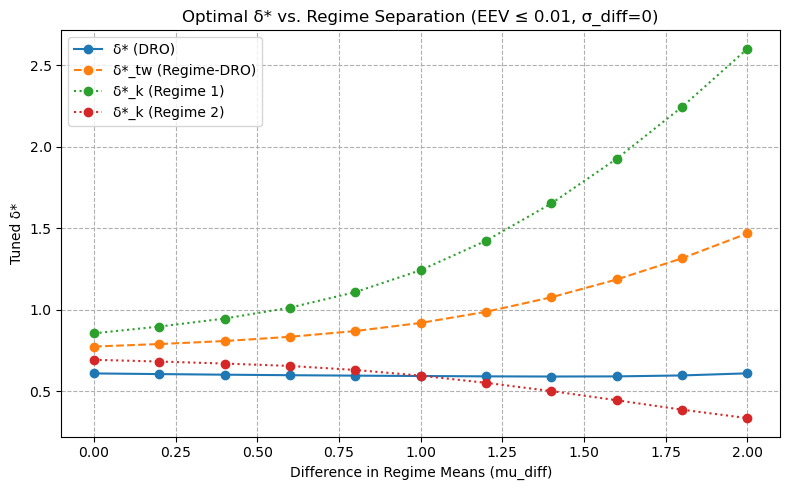

In [16]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Optimal δ* vs. mu_diff (with sigma_diff = 0)
# --------------------------------------------------

EEV_TARGET_FINAL = 0.01
mu_diff_final_grid = np.arange(0.0, 2.2, 0.2)

# Base specs (one for global DRO, one for Regime-DRO)
try:
    spec_dro = next(p for p in PORTFOLIOS if _base_name(p["name"]) == "DRO")
    spec_regime = next(p for p in PORTFOLIOS if _base_name(p["name"]) == "Regime-DRO")
except StopIteration:
    raise ValueError("Missing base specs for DRO / Regime-DRO in PORTFOLIOS.")

BASE_DATA_SPEC = copy.deepcopy(DATA_SPEC)

rows_avg = []   # per-mu_diff: δ*_DRO, δ*_RegimeDRO (time-weighted)
rows_seg = []   # per-mu_diff, per-segment: δ*_k

print("Starting mu_diff sweep (sigma_diff=0)...")
for mu_d in mu_diff_final_grid:
    print(f"  mu_diff = {mu_d:.2f}")
    # Data config for this mu_diff (σ_diff pinned to 0)
    current_spec = copy.deepcopy(BASE_DATA_SPEC)
    current_spec["gbm"]["range_mu_diff"] = [mu_d, mu_d]
    current_spec["gbm"]["range_sigma_diff"] = [0.0, 0.0]

    CURRENT_GLOBAL = copy.deepcopy(GLOBAL)        # keep seeds fixed
    data_cache = build_data_cache(CURRENT_GLOBAL, current_spec)

    # Global DRO: scalar δ tuned to EEV target
    delta_dro_star, _ = tune_delta_eev_for_spec(
        CURRENT_GLOBAL, data_cache, spec_dro,
        eev_target=EEV_TARGET_FINAL, d_hi=2.0, tol=1e-4
    )

    # Regime-DRO: per-segment δ_k tuned to per-segment EEV target
    segs = data_cache[0]["taus_true"]
    delta_list_regime = tune_delta_eev_per_segment(
        CURRENT_GLOBAL, data_cache, spec_regime, segs,
        eev_target=EEV_TARGET_FINAL, d_hi=2.0, tol=1e-4
    )
    # Time-weighted average δ for Regime-DRO
    wts = np.diff(np.array(segs))
    delta_tw = float(np.average(delta_list_regime, weights=wts))

    # Record averages
    rows_avg.append({
        "mu_diff": float(mu_d),
        "delta_DRO": float(delta_dro_star),
        "delta_RegimeDRO": delta_tw
    })
    # Record per-segment deltas
    for k, dk in enumerate(delta_list_regime, start=1):
        rows_seg.append({
            "mu_diff": float(mu_d),
            "segment": int(k),
            "delta_k": float(dk)
        })

print("Sweep complete.")

# -------- Tables --------
df_avg = pd.DataFrame(rows_avg).set_index("mu_diff").sort_index()
df_seg = pd.DataFrame(rows_seg)
seg_pivot = (df_seg.pivot(index="mu_diff", columns="segment", values="delta_k")
                  .sort_index()
                  .rename_axis(None, axis=1))

print("\n" + "="*80)
print(f"Optimal δ* tuned to EEV ≤ {EEV_TARGET_FINAL} vs. mu_diff (sigma_diff=0)")
print("="*80)
with pd.option_context("display.width", 160):
    print(df_avg)
    if not seg_pivot.empty:
        print("\nPer-segment δ_k*:")
        print(seg_pivot)

# -------- Plot --------
plt.figure(figsize=(8, 5))
df_avg["delta_DRO"].plot(marker="o", label="δ* (DRO)")
df_avg["delta_RegimeDRO"].plot(marker="o", linestyle="--", label="δ*_tw (Regime-DRO)")
if not seg_pivot.empty:
    for k in seg_pivot.columns:
        plt.plot(seg_pivot.index.values, seg_pivot[k].values,
                 marker="o", linestyle=":", label=f"δ*_k (Regime {int(k)})")
plt.xlabel("Difference in Regime Means (mu_diff)")
plt.ylabel("Tuned δ*")
plt.title(f"Optimal δ* vs. Regime Separation (EEV ≤ {EEV_TARGET_FINAL}, σ_diff=0)")
plt.grid(True, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


Starting sigma_diff sweep (mu_diff fixed)...
  sigma_diff = 0.00
  sigma_diff = 0.20
  sigma_diff = 0.40
  sigma_diff = 0.60
  sigma_diff = 0.80
  sigma_diff = 1.00
  sigma_diff = 1.20
  sigma_diff = 1.40
  sigma_diff = 1.60
  sigma_diff = 1.80
  sigma_diff = 2.00
Sweep complete.

Optimal δ* tuned to EEV ≤ 0.01 vs. sigma_diff (mu_diff=0.4)
            delta_DRO  delta_RegimeDRO
sigma_diff                            
0.0          0.602356         0.808685
0.2          0.942200         1.071869
0.4          1.465210         1.544189
0.6          1.881897         2.119751
0.8          2.369080         2.832764
1.0          2.921265         3.744049
1.2          3.381165         4.957184
1.4          3.748962         6.556610
1.6          4.116394         8.678375
1.8          4.526672        11.516205
2.0          5.110413        15.365662

Per-segment δ_k*:
                   1          2
sigma_diff                     
0.0         0.946716   0.670654
0.2         0.000000   2.143738
0.4 

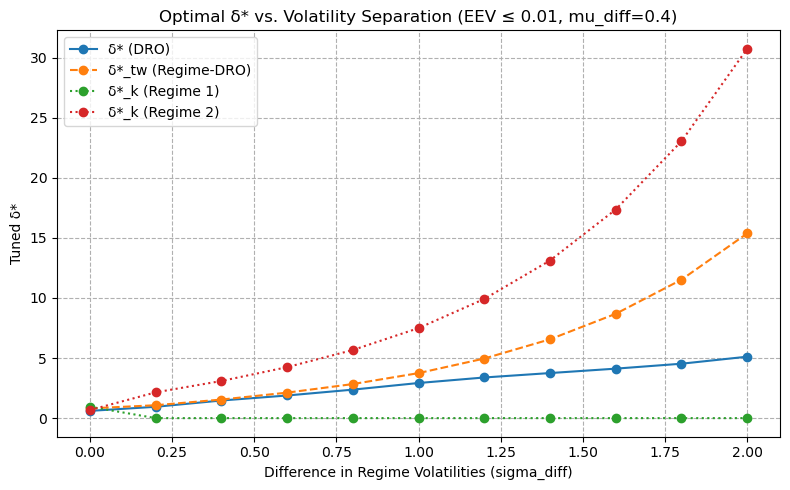

In [23]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Optimal δ* vs. sigma_diff (with mu_diff fixed)
# --------------------------------------------------

EEV_TARGET_FINAL = 0.01
MU_DIFF_FIXED = 0.4                      # <- set your fixed mu_diff here
sigma_diff_final_grid = np.arange(0.0, 2.2, 0.2)

# Base specs (one for global DRO, one for Regime-DRO)
try:
    spec_dro = next(p for p in PORTFOLIOS if _base_name(p["name"]) == "DRO")
    spec_regime = next(p for p in PORTFOLIOS if _base_name(p["name"]) == "Regime-DRO")
except StopIteration:
    raise ValueError("Missing base specs for DRO / Regime-DRO in PORTFOLIOS.")

BASE_DATA_SPEC = copy.deepcopy(DATA_SPEC)

rows_avg = []   # per-sigma_diff: δ*_DRO, δ*_RegimeDRO (time-weighted)
rows_seg = []   # per-sigma_diff, per-segment: δ*_k

print("Starting sigma_diff sweep (mu_diff fixed)...")
for sd in sigma_diff_final_grid:
    print(f"  sigma_diff = {sd:.2f}")
    # Data config for this sigma_diff (μ_diff pinned to MU_DIFF_FIXED)
    current_spec = copy.deepcopy(BASE_DATA_SPEC)
    current_spec["gbm"]["range_mu_diff"] = [MU_DIFF_FIXED, MU_DIFF_FIXED]
    current_spec["gbm"]["range_sigma_diff"] = [sd, sd]

    CURRENT_GLOBAL = copy.deepcopy(GLOBAL)        # keep seeds fixed
    data_cache = build_data_cache(CURRENT_GLOBAL, current_spec)

    # Global DRO: scalar δ tuned to EEV target
    delta_dro_star, _ = tune_delta_eev_for_spec(
        CURRENT_GLOBAL, data_cache, spec_dro,
        eev_target=EEV_TARGET_FINAL, d_hi=2.0, tol=1e-4
    )

    # Regime-DRO: per-segment δ_k tuned to per-segment EEV target
    segs = data_cache[0]["taus_true"]
    delta_list_regime = tune_delta_eev_per_segment(
        CURRENT_GLOBAL, data_cache, spec_regime, segs,
        eev_target=EEV_TARGET_FINAL, d_hi=2.0, tol=1e-4
    )
    # Time-weighted average δ for Regime-DRO
    wts = np.diff(np.array(segs))
    delta_tw = float(np.average(delta_list_regime, weights=wts))

    # Record averages
    rows_avg.append({
        "sigma_diff": float(sd),
        "delta_DRO": float(delta_dro_star),
        "delta_RegimeDRO": delta_tw
    })
    # Record per-segment deltas
    for k, dk in enumerate(delta_list_regime, start=1):
        rows_seg.append({
            "sigma_diff": float(sd),
            "segment": int(k),
            "delta_k": float(dk)
        })

print("Sweep complete.")

# -------- Tables --------
df_avg = pd.DataFrame(rows_avg).set_index("sigma_diff").sort_index()
df_seg = pd.DataFrame(rows_seg)
seg_pivot = (df_seg.pivot(index="sigma_diff", columns="segment", values="delta_k")
                  .sort_index()
                  .rename_axis(None, axis=1))

print("\n" + "="*80)
print(f"Optimal δ* tuned to EEV ≤ {EEV_TARGET_FINAL} vs. sigma_diff (mu_diff={MU_DIFF_FIXED})")
print("="*80)
with pd.option_context("display.width", 160):
    print(df_avg)
    if not seg_pivot.empty:
        print("\nPer-segment δ_k*:")
        print(seg_pivot)

# -------- Plot --------
plt.figure(figsize=(8, 5))
df_avg["delta_DRO"].plot(marker="o", label="δ* (DRO)")
df_avg["delta_RegimeDRO"].plot(marker="o", linestyle="--", label="δ*_tw (Regime-DRO)")
if not seg_pivot.empty:
    for k in seg_pivot.columns:
        plt.plot(seg_pivot.index.values, seg_pivot[k].values,
                 marker="o", linestyle=":", label=f"δ*_k (Regime {int(k)})")
plt.xlabel("Difference in Regime Volatilities (sigma_diff)")
plt.ylabel("Tuned δ*")
plt.title(f"Optimal δ* vs. Volatility Separation (EEV ≤ {EEV_TARGET_FINAL}, mu_diff={MU_DIFF_FIXED})")
plt.grid(True, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()
